In [85]:
import  numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px
import plotly.graph_objects as go

from pycountry_convert import country_name_to_country_alpha3, country_alpha2_to_country_name

from sklearn.preprocessing import OneHotEncoder
from scipy.stats import f_oneway, f
import statsmodels.api as sm
from statsmodels.formula.api import ols
import warnings
warnings.simplefilter('ignore')

In [66]:
pd.set_option('display.max_rows', 100)
data = pd.read_csv('./data/human_trafficking.csv', low_memory=False)

In [67]:
#data.RecruiterRelationship.unique()

In [68]:
data.replace('-99', np.nan, inplace=True)
data.replace(-99, np.nan, inplace=True)
data = data[~data.ageBroad.isna() & ~data.citizenship.isna() & ~data.CountryOfExploitation.isna()]
data.drop(columns=['majorityStatusAtExploit', 'majorityEntry'], inplace=True)
data.replace(np.nan, 0, inplace=True)
data['RecruiterRelationship'].replace(0, np.nan, inplace=True)
data['typeOfExploitConcatenated'].replace(0, np.nan, inplace=True)
data.isna().sum() / len(data.index)

#data['majorityStatusAtExploit'].unique()

yearOfRegistration                        0.000000
Datasource                                0.000000
gender                                    0.000000
ageBroad                                  0.000000
majorityStatus                            0.000000
citizenship                               0.000000
meansOfControlDebtBondage                 0.000000
meansOfControlTakesEarnings               0.000000
meansOfControlRestrictsFinancialAccess    0.000000
meansOfControlThreats                     0.000000
meansOfControlPsychologicalAbuse          0.000000
meansOfControlPhysicalAbuse               0.000000
meansOfControlSexualAbuse                 0.000000
meansOfControlFalsePromises               0.000000
meansOfControlPsychoactiveSubstances      0.000000
meansOfControlRestrictsMovement           0.000000
meansOfControlRestrictsMedicalCare        0.000000
meansOfControlExcessiveWorkingHours       0.000000
meansOfControlUsesChildren                0.000000
meansOfControlThreatOfLawEnforc

In [69]:
def get_alpha3(col):
    try:
        iso_3 =  country_name_to_country_alpha3(col)
    except:
        iso_3 = 'Unknown'
    return iso_3

def get_name(col):
    try:
        name =  country_alpha2_to_country_name(col)
    except:
        name = 'Unknown'
    return name

In [70]:
data['countryCitizenship'] = data['citizenship'].apply(lambda x: get_name(x))
data['alpha3Citizenship'] = data['countryCitizenship'].apply(lambda x: get_alpha3(x))

data['CountryOfExploitation'] = data['CountryOfExploitation'].apply(lambda x: get_name(x))
data['alpha3CountryOfExploitation'] = data['CountryOfExploitation'].apply(lambda x: get_alpha3(x))

In [71]:
df_origin = pd.DataFrame(data.groupby(['countryCitizenship', 'alpha3Citizenship'])['alpha3Citizenship'].agg(victims='count')).reset_index()

fig = px.choropleth(df_origin, locations="alpha3Citizenship",
                    color="victims",
                    hover_name="countryCitizenship",
                    color_continuous_scale='Viridis_r')
#fig.update_layout(title_text="Human Trafficking Victims")
fig.show()

In [72]:
df_origin.sort_values('victims', ascending=False)[:6]

formula = 'victims ~ C(alpha3Citizenship)'
ols_lm = ols(formula, data=df_origin).fit()
anova_table = sm.stats.anova_lm(ols_lm, typ=1)
anova_table

# No funcionaaaa

,df,sum_sq,mean_sq,F,PR(>F)
C(alpha3Citizenship),44.0,1.609086e+08,3.657013e+06,0.0,NaN
Residual,0.0,1.894727e-22,inf,NaN,NaN


In [73]:
df_destination = pd.DataFrame(data.groupby(['CountryOfExploitation', 'alpha3CountryOfExploitation'])['alpha3CountryOfExploitation'].agg(agresors='count')).reset_index()

fig = px.choropleth(df_destination, locations="alpha3CountryOfExploitation",
                    color="agresors",
                    hover_name="CountryOfExploitation",
                    color_continuous_scale='Viridis_r')
#fig.update_layout(title_text="Human Trafficking Victims")
fig.show()

In [74]:
df_destination['alpha3CountryOfExploitation'].size

56

In [75]:
'''
df_origin.rename(columns = {'alpha3Citizenship':'iso3', 'countryCitizenship':'name', 'victims':'Out'}, inplace = True)
df_destination.rename(columns = {'alpha3CountryOfExploitation':'iso3', 'CountryOfExploitation':'name','agresors':'In'}, inplace = True)

df_flow = pd.merge(df_origin, df_destination, how='outer', on=['iso3','name'])
df_flow.replace(np.nan, 1, inplace=True)
df_flow['Human Trafficking Flow'] = df_flow['Out'] - df_flow['In']
df_flow['Flow (Log Scale)'] = np.log(np.abs(df_flow['Out'] - df_flow['In'])) * np.sign(df_flow['Out'] - df_flow['In'])

fig = px.choropleth(df_flow, locations="iso3", color="Flow (Log Scale)", hover_name="name", color_continuous_scale='Viridis_r')
fig.show()
'''

'\ndf_origin.rename(columns = {\'alpha3Citizenship\':\'iso3\', \'countryCitizenship\':\'name\', \'victims\':\'Out\'}, inplace = True)\ndf_destination.rename(columns = {\'alpha3CountryOfExploitation\':\'iso3\', \'CountryOfExploitation\':\'name\',\'agresors\':\'In\'}, inplace = True)\n\ndf_flow = pd.merge(df_origin, df_destination, how=\'outer\', on=[\'iso3\',\'name\'])\ndf_flow.replace(np.nan, 1, inplace=True)\ndf_flow[\'Human Trafficking Flow\'] = df_flow[\'Out\'] - df_flow[\'In\']\ndf_flow[\'Flow (Log Scale)\'] = np.log(np.abs(df_flow[\'Out\'] - df_flow[\'In\'])) * np.sign(df_flow[\'Out\'] - df_flow[\'In\'])\n\nfig = px.choropleth(df_flow, locations="iso3", color="Flow (Log Scale)", hover_name="name", color_continuous_scale=\'Viridis_r\')\nfig.show()\n'

In [76]:
data['Victims'] = 1
fig = px.sunburst(data[data.ageBroad.notna()], path=['gender', 'ageBroad'], values='Victims', color='gender')
fig.update_layout(width=600, height=600)
fig.show()

In [77]:
data_bar_mg = pd.DataFrame(data.groupby(['gender', 'majorityStatus'])['majorityStatus'].agg(Victims='count')).reset_index()

fig = px.bar(data_bar_mg, x="majorityStatus", y="Victims", color="gender",
            labels={'majorityStatus':'Majority Status'})
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.update_layout(hovermode='x')
fig.show()

In [78]:
data['meansOfControlConcatenated'] = data['meansOfControlConcatenated'].str.replace('Abuse', 'abuse', regex=True)
data_bar_f = data[(data.meansOfControlConcatenated.notna()) & (data.gender == 'Female')].meansOfControlConcatenated.apply(lambda x: pd.value_counts(str(x).split(";"))).sum(axis = 0)
data_bar_m = data[(data.meansOfControlConcatenated.notna()) & (data.gender == 'Male')].meansOfControlConcatenated.apply(lambda x: pd.value_counts(str(x).split(";"))).sum(axis = 0)
fig = go.Figure(data=[
    go.Bar(name='Female', x=data_bar_f.index, y=data_bar_f),
    go.Bar(name='Male', x=data_bar_m.index, y=data_bar_m)
])
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.update_layout(hovermode='x')
fig.show()

In [79]:
data_bar_f = data[(data.typeOfExploitConcatenated.notna()) & (data.gender == 'Female')].typeOfExploitConcatenated.apply(lambda x: pd.value_counts(str(x).split(";"))).sum(axis = 0)
data_bar_m = data[(data.typeOfExploitConcatenated.notna()) & (data.gender == 'Male')].typeOfExploitConcatenated.apply(lambda x: pd.value_counts(str(x).split(";"))).sum(axis = 0)
fig = go.Figure(data=[
    go.Bar(name='Female', x=data_bar_f.index, y=data_bar_f),
    go.Bar(name='Male', x=data_bar_m.index, y=data_bar_m)
])
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.show()

In [80]:
data_bar_f = data[(data.RecruiterRelationship.notna()) & (data.gender == 'Female')].RecruiterRelationship.apply(lambda x: pd.value_counts(str(x).split("; "))).sum(axis = 0)
data_bar_m = data[(data.RecruiterRelationship.notna()) & (data.gender == 'Male')].RecruiterRelationship.apply(lambda x: pd.value_counts(str(x).split("; "))).sum(axis = 0)
fig = go.Figure(data=[
    go.Bar(name='Female', x=data_bar_f.index, y=data_bar_f),
    go.Bar(name='Male', x=data_bar_m.index, y=data_bar_m)
])
fig.update_traces(texttemplate='%{value}', textposition='outside')
fig.show()

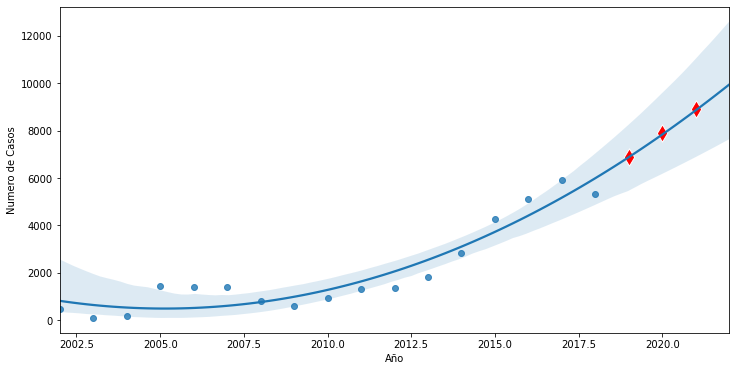

In [81]:
count_by_years = data[data['yearOfRegistration'] != 2019]['yearOfRegistration'].value_counts().reset_index().sort_values('index')

fig = plt.figure(figsize=(12,6))

plt.xlim(2002,2022)
sns.regplot(x=count_by_years['index'], y=count_by_years.yearOfRegistration, order=2, truncate=False)
sns.scatterplot(x=[2019, 2020, 2021], y=[6900, 7900, 8900], marker='d', color='red', s=150)
plt.ylabel('Numero de Casos')
plt.xlabel('Año');


In [113]:
data['age'] = data['ageBroad'].str.extract('(\d+)')

In [114]:
origin = pd.get_dummies(data['alpha3Citizenship'], prefix='origin')
destination = pd.get_dummies(data['alpha3CountryOfExploitation'], prefix='destination')
gender = pd.get_dummies(data['gender'], prefix='sex')

In [115]:
df = pd.concat((data, origin, destination, gender), axis=1)

cols = df.columns
cols = [c for c in cols if 'origin' in c or 'destination' in c or 'sex' in c]
cols += ['age']
cols
df = df[cols]
df

,origin_AFG,origin_ALB,origin_BFA,origin_BGD,origin_BGR,origin_BLR,origin_BOL,origin_CHN,origin_CIV,origin_COD,...,destination_UGA,destination_UKR,destination_USA,destination_UZB,destination_Unknown,destination_VNM,destination_ZAF,sex_Female,sex_Male,age
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18
105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18
106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18
107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48782,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,30
48783,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,30
48784,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,30
48785,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,30


In [116]:
from sklearn.decomposition import PCA
pca = PCA() # Initialize with n_components parameter to only find the top eigenvectors
z = pca.fit_transform(df)

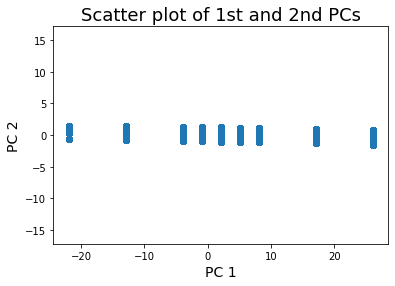

In [117]:
plt.scatter(z[:,0],z[:,1])
plt.title("Scatter plot of 1st and 2nd PCs",size=18)
plt.xlabel("PC 1",size=14)
plt.ylabel("PC 2",size=14)
plt.axis("equal")
plt.show()

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(df)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],)
plt.title("MDS Plot",size=18)
plt.axis("equal")
plt.show()